In [1]:
import polars as pl
import pandas as pd
from polars.testing import assert_frame_equal
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import glob
music_files = glob.glob("Data/*music*.json")
df = pl.concat([pl.read_json(f) for f in music_files], how="diagonal")
df.head()

endTime,artistName,trackName,msPlayed
str,str,str,i64
"""2025-03-20 08:22""","""Doja Cat""","""Go Off""",197078
"""2025-03-20 08:25""","""Doja Cat""","""Shutcho""",187246
"""2025-03-20 08:29""","""Doja Cat""","""Agora Hills""",264917
"""2025-03-20 08:40""","""Doja Cat""","""Can't Wait""",211496
"""2025-03-20 12:14""","""Victoria Monét""","""Coastin’""",175319


In [3]:
podcast_files = glob.glob("Data/*podcast*.json")
df_podcasts = pl.concat([pl.read_json(f) for f in podcast_files], how="diagonal")
df_podcasts.head()

endTime,podcastName,episodeName,msPlayed
str,str,str,i64
"""2024-10-12 13:23""","""REI SPEAKS""","""Episode 2 | ""Being the bonus f…",38405
"""2024-10-12 13:24""","""Unobscured Vns""","""I'm sad :(""",10580
"""2024-10-12 13:55""","""SLUMBER STORIES""","""Episode 2 (trailer) | ""Being t…",23512
"""2024-10-12 13:55""","""SLUMBER STORIES""","""Episode 2 | ""Being the bonus f…",1869568
"""2024-10-12 14:12""","""SLUMBER STORIES""","""Episode 3 | ""It's difficult fo…",305979


In [4]:
df = df.with_columns(
    pl.col("endTime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M")
)

df = df.with_columns([
    pl.col("endTime").dt.date().alias("date"),
    pl.col("endTime").dt.hour().alias("hour"),
    pl.col("endTime").dt.day().alias("day")
])

Note: you may need to restart the kernel to use updated packages.


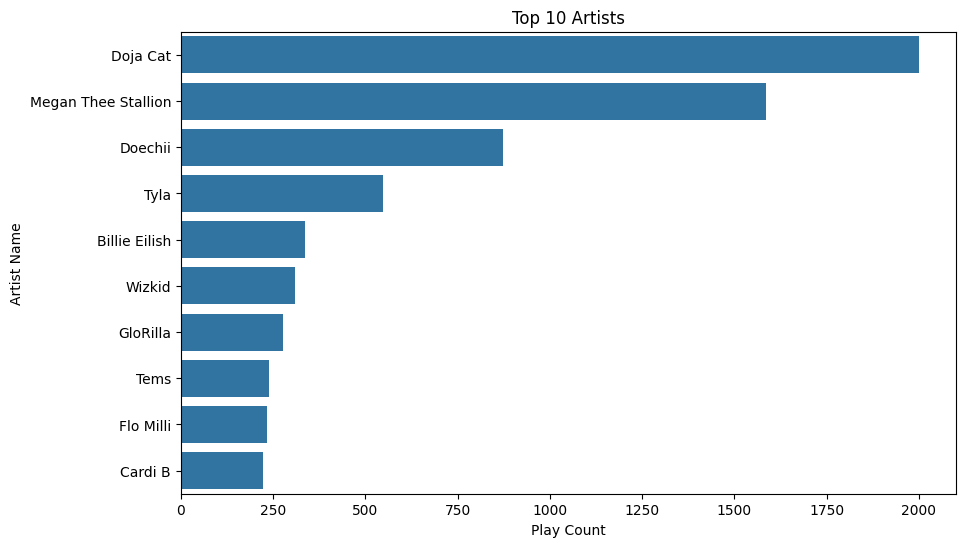

In [5]:
%pip install pyarrow

top_artists = (
    df
    .group_by("artistName")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(10)
    .to_pandas()
)

plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="artistName", data=top_artists)
plt.title("Top 10 Artists")
plt.xlabel("Play Count")
plt.ylabel("Artist Name")
plt.show()

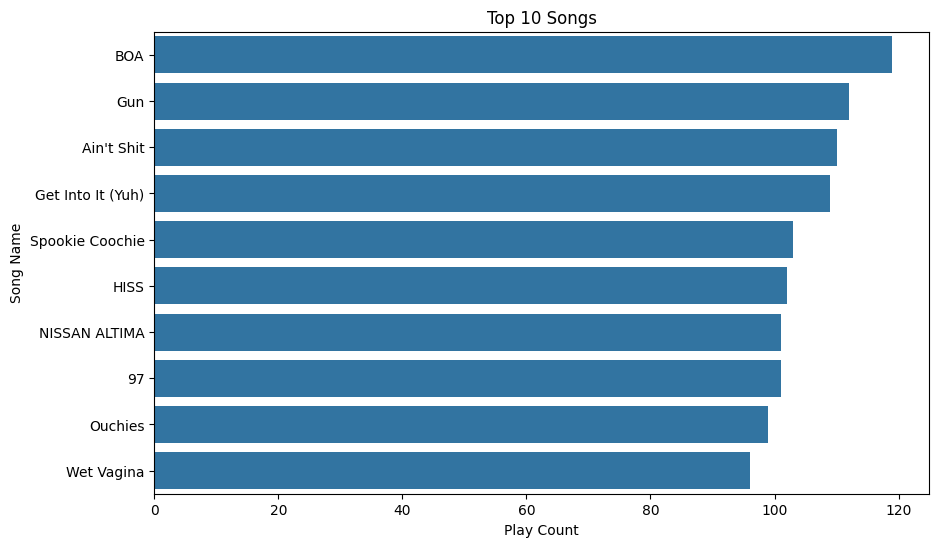

In [6]:
top_songs = (
    df
    .group_by("trackName")
    .agg(pl.len().alias("count"))
    .sort("count", descending=True)
    .head(10)
    .to_pandas()
)

plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="trackName", data=top_songs)
plt.title("Top 10 Songs")
plt.xlabel("Play Count")
plt.ylabel("Song Name")
plt.show()

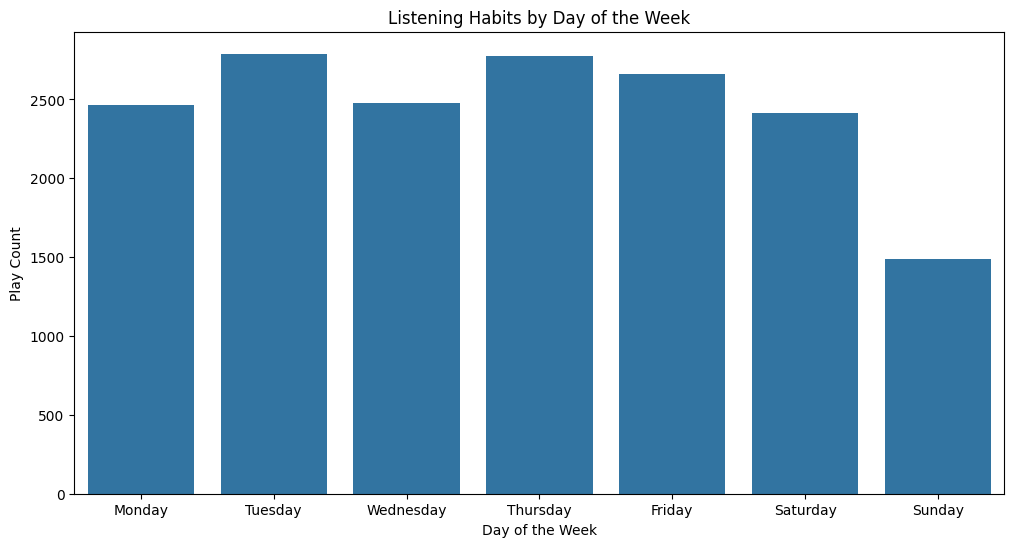

In [7]:
import calendar
import pandas as pd

df = df.with_columns(
    pl.col("date").dt.weekday().alias("weekday_num")
)

# Convert to pandas for mapping and plotting
df_pd = df.to_pandas()

# Only map valid weekday numbers (1–7)
def safe_day_name(x):
    if pd.notnull(x) and 1 <= int(x) <= 7:
        return calendar.day_name[int(x) - 1]
    else:
        return None

df_pd["weekday"] = df_pd["weekday_num"].apply(safe_day_name)

plt.figure(figsize=(12, 6))
sns.countplot(
    x='weekday',
    data=df_pd,
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.title("Listening Habits by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Play Count")
plt.show()

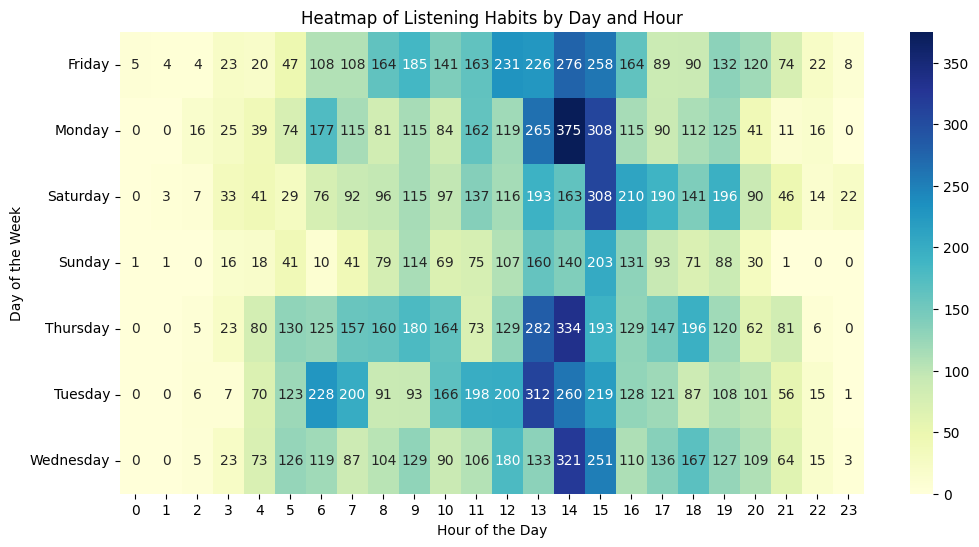

In [8]:
heatmap_data = df_pd.groupby(['weekday', 'hour']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Heatmap of Listening Habits by Day and Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()

In [9]:
print(df_pd.columns)

Index(['endTime', 'artistName', 'trackName', 'msPlayed', 'date', 'hour', 'day',
       'weekday_num', 'weekday'],
      dtype='object')


In [10]:
print(df_podcasts.columns)

['endTime', 'podcastName', 'episodeName', 'msPlayed']


/tmp/ipykernel_70960/433490331.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_podcasts.values, y=top_podcasts.index, palette="viridis")
/home/makena-wahu/CODEWRLD/SevveredFloor/SpotifyWrapped/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127800 (\N{CHERRY BLOSSOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


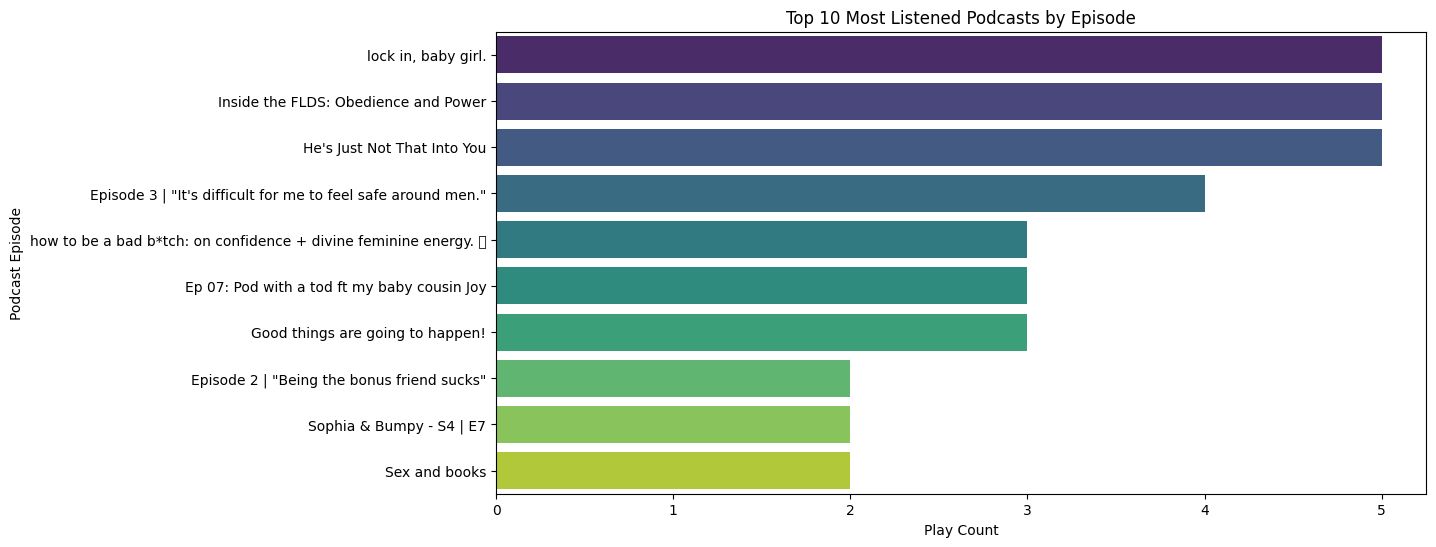

In [11]:
df_podcasts_pd = df_podcasts.to_pandas()
top_podcasts = df_podcasts_pd['episodeName'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_podcasts.values, y=top_podcasts.index, palette="viridis")
plt.title("Top 10 Most Listened Podcasts by Episode")
plt.xlabel("Play Count")
plt.ylabel("Podcast Episode")
plt.show()

In [12]:
df = df.with_columns([
    (pl.col("msPlayed") / 60000).alias("minutesPlayed"),
    (pl.col("msPlayed") / (1000 * 60 * 60)).alias("hoursPlayed")
])

total_minutes = df["minutesPlayed"].sum()
total_hours = df["hoursPlayed"].sum()
total_days = total_hours / 24

print(f"🎵 Total Minutes Played: {total_minutes:.2f} minutes")
print(f"🎵 Total Hours Played: {total_hours:.2f} hours")
print(f"🎵 Total Days Played: {total_days:.2f} days")


🎵 Total Minutes Played: 44864.71 minutes
🎵 Total Hours Played: 747.75 hours
🎵 Total Days Played: 31.16 days


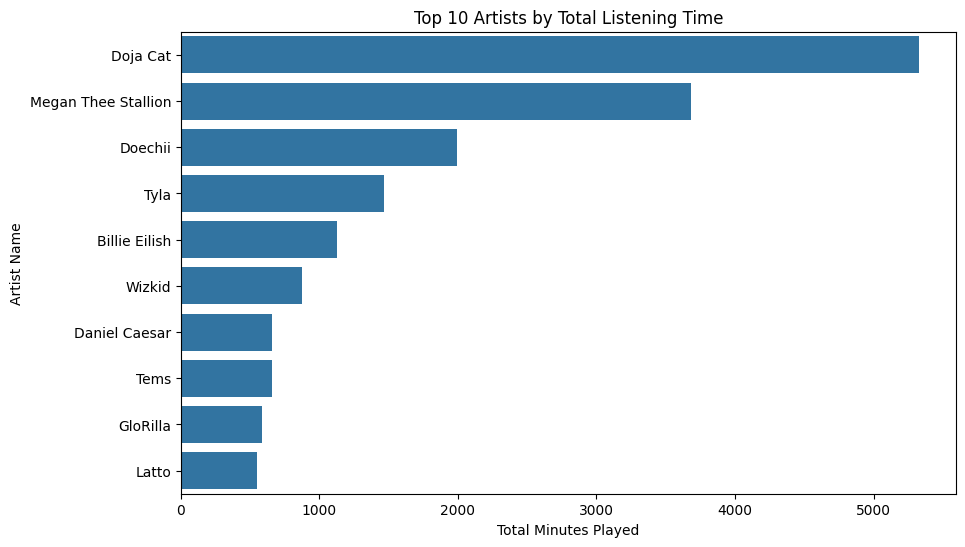

In [13]:
artist_time = df.group_by("artistName").agg(pl.col("minutesPlayed").sum().alias("totalMinutes")).sort("totalMinutes", descending=True).head(10).to_pandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="totalMinutes", y="artistName", data=artist_time)
plt.title("Top 10 Artists by Total Listening Time")
plt.xlabel("Total Minutes Played")
plt.ylabel("Artist Name")
plt.show()

In [14]:
print(df.columns)

['endTime', 'artistName', 'trackName', 'msPlayed', 'date', 'hour', 'day', 'weekday_num', 'minutesPlayed', 'hoursPlayed']


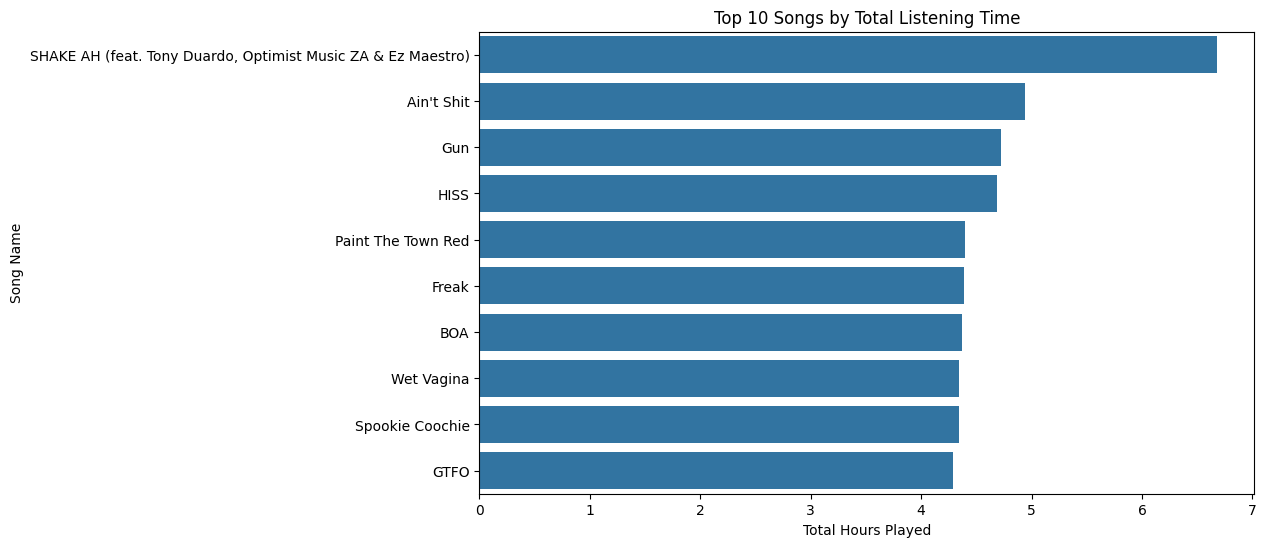

In [15]:
song_time = (
    df
    .group_by("trackName")
    .agg(pl.col("hoursPlayed").sum().alias("totalHours"))
    .sort("totalHours", descending=True)
    .head(10)
    .to_pandas()
)

plt.figure(figsize=(10, 6))
sns.barplot(x="totalHours", y="trackName", data=song_time)
plt.title("Top 10 Songs by Total Listening Time")
plt.xlabel("Total Hours Played")
plt.ylabel("Song Name")
plt.show()